In [1]:
# loading package
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
# loading data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
# combine data
df_data = pd.concat([df_train, df_test], axis=0, sort=True)
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.filterwarnings("ignore")

,Sex,Survived
0,female,0.742
1,male,0.189


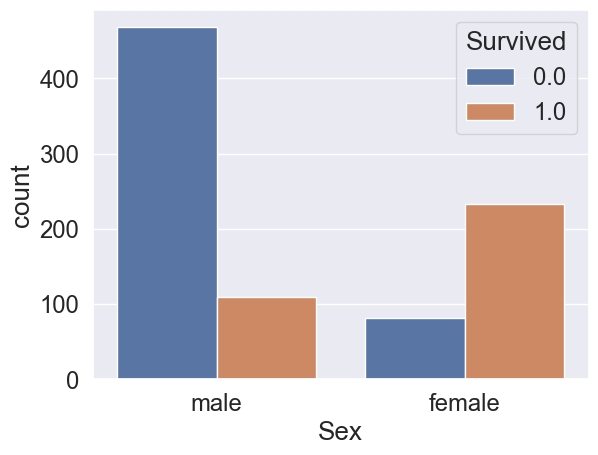

In [2]:
sns.countplot(x='Sex', hue='Survived', data=df_data)
display(df_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(3))

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


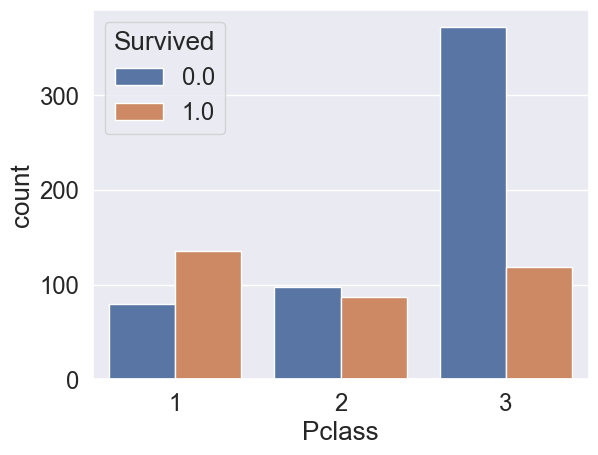

In [3]:
sns.countplot(x='Pclass', hue='Survived', data=df_data)
df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)

In [4]:
# Convert Sex
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')

In [5]:
# split training set the testing set
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [6]:
# Inputs set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [7]:
# Show Baseline
Base = ['Sex_Code','Pclass']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))

Base oob score :0.73176


In [8]:
# submission if you want
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

Base_pred = Base_Model.predict(X_Submit[Base])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":Base_pred.astype(int)})
submit.to_csv("submit_Base.csv",index=False)

Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

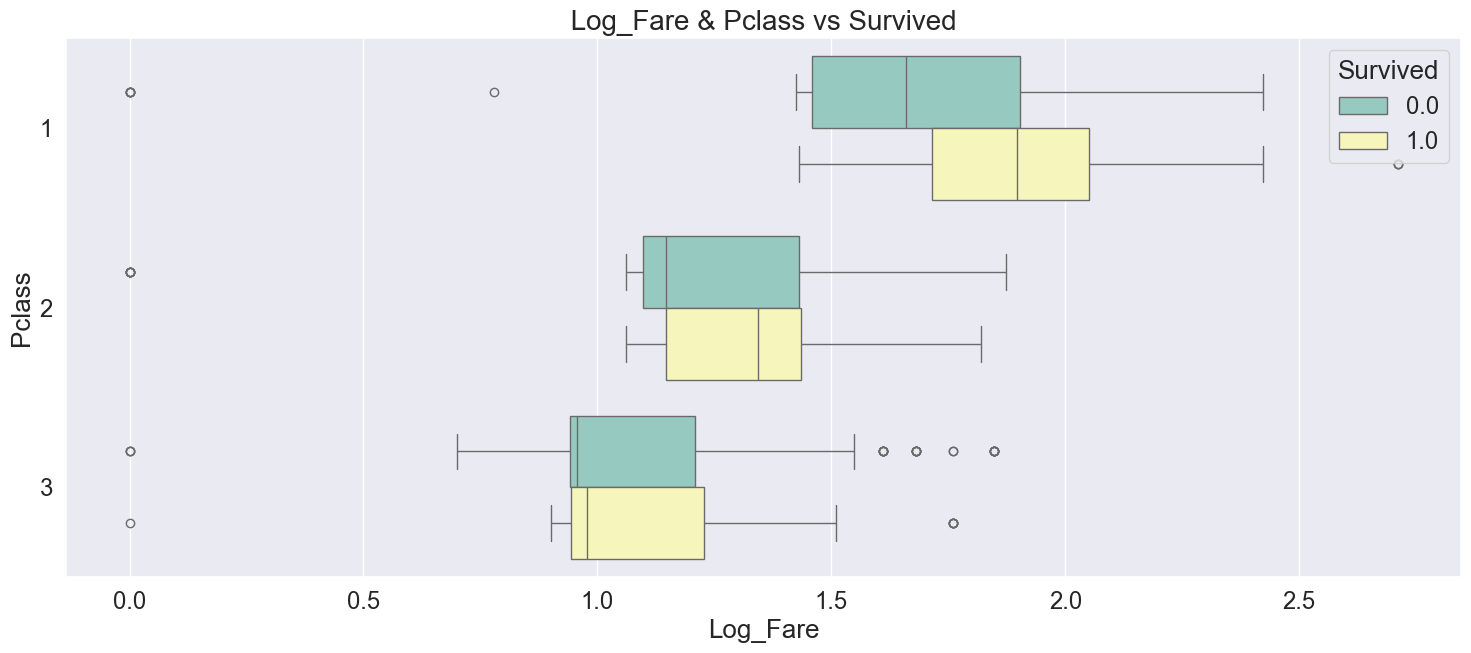

In [9]:
# there is some bugs in log-scale of boxplot. 
# alternatively, we transform x into log10(x) for visualization.
fig, ax = plt.subplots( figsize = (18,7) )
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare',hue='Survived',data=df_data, orient='h'
                ,ax=ax,palette="Set3")
ax.set_title(' Log_Fare & Pclass vs Survived ',fontsize = 20)
pd.pivot_table(df_data,values = ['Fare'], index = ['Pclass'], columns= ['Survived'] ,aggfunc = 'median' ).round(3) #票價中位數

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


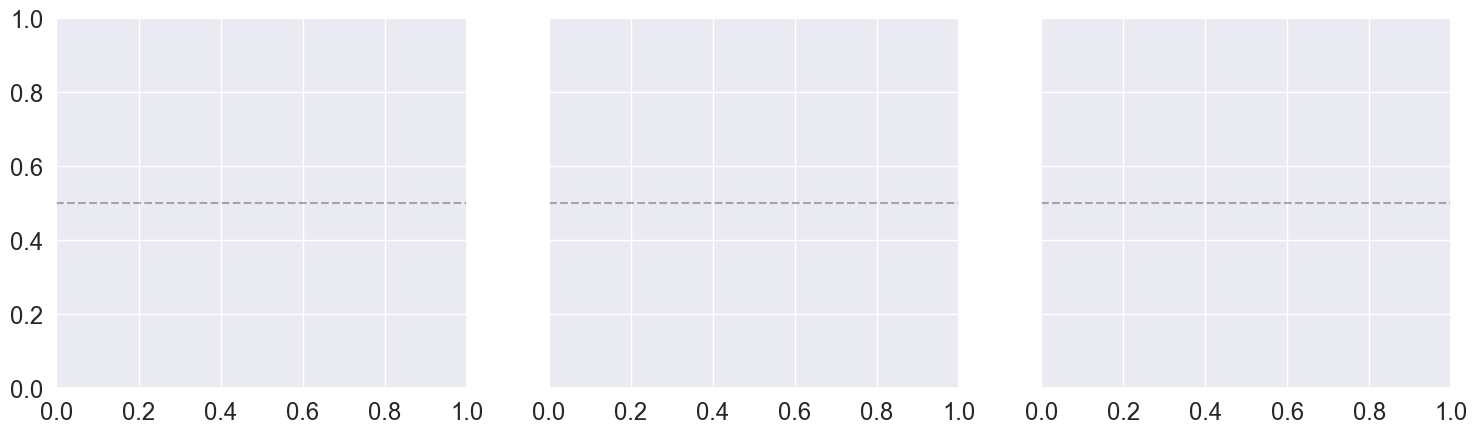

In [10]:
# Filling missing values
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

# Making Bins 創建票價區間
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

label = LabelEncoder()
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])

# cross tab
df_4 = pd.crosstab(df_data['FareBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5,linestyle='dashed', c='black',alpha = .3)
g1 = sns.catplot(x='FareBin_Code_4', y='Survived', data=df_data, kind='bar', ax=ax1)
g2 = sns.catplot(x='FareBin_Code_5', y='Survived', data=df_data, kind='bar', ax=ax2)
g3 = sns.catplot(x='FareBin_Code_6', y='Survived', data=df_data, kind='bar', ax=ax3)
# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

In [11]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
# show columns
X.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_Code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

In [12]:
compare = ['Sex_Code','Pclass','FareBin_Code_4','FareBin_Code_5','FareBin_Code_6']
selector = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X[compare], Y)
print(selector.support_) #表示每個特徵是否被選中
print(selector.ranking_) #顯示每個特徵的排名
print(selector.cv_results_['mean_test_score'] * 100)

[ True  True  True  True  True]
[1 1 1 1 1]
[78.67290886 77.33208489 79.24219725 79.24344569 80.1423221 ]


In [13]:
#評估不同票價區間特徵在模型中的重要性
score_b4,score_b5, score_b6 = [], [], []
seeds = 10 #進行 10 次隨機取樣和交叉驗證
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    selector = RFECV(RandomForestClassifier(random_state=i,n_estimators=250,min_samples_split=20),cv=diff_cv,n_jobs=-1)
    selector.fit(X[compare], Y)
    score_b4.append(selector.cv_results_['mean_test_score'][2])
    score_b5.append(selector.cv_results_['mean_test_score'][3])
    score_b6.append(selector.cv_results_['mean_test_score'][4])

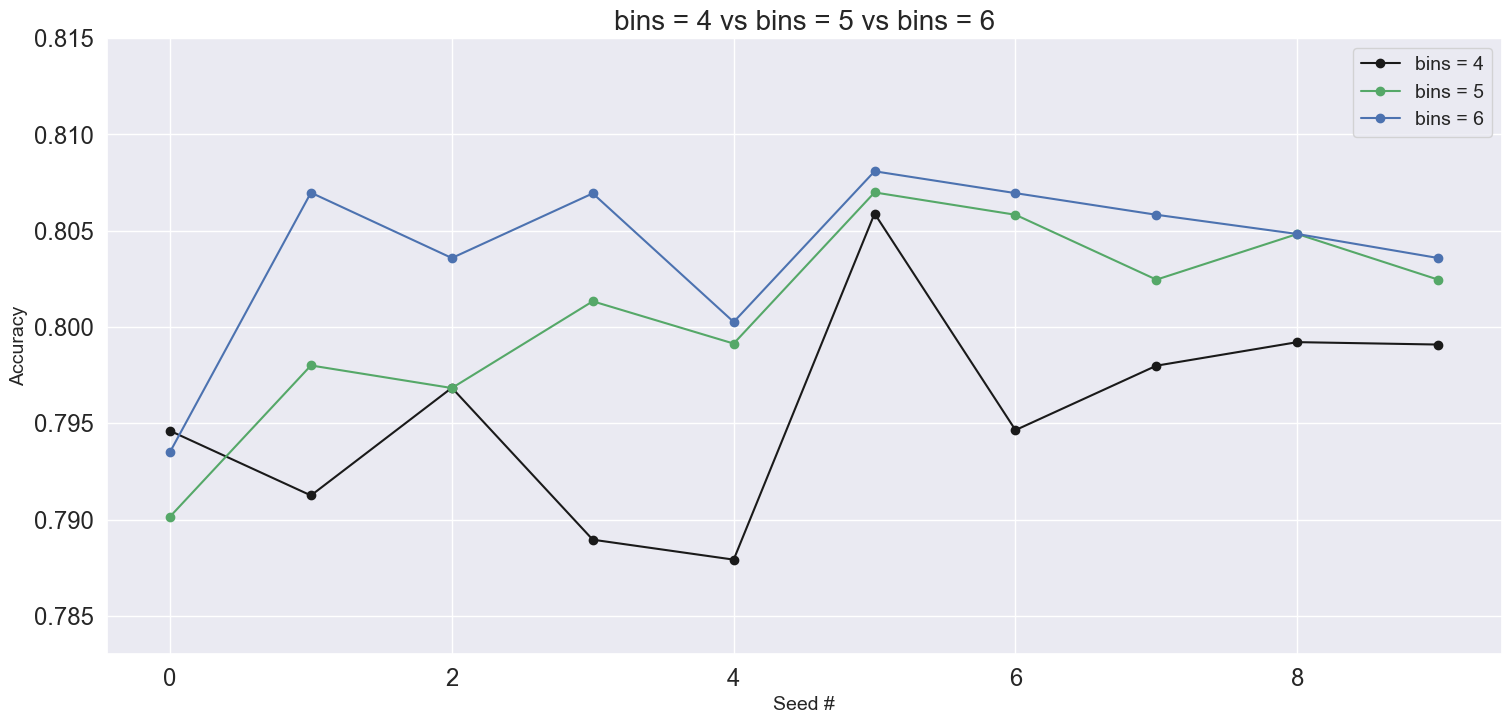

In [14]:
# to np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)
# plot
fig = plt.figure(figsize= (18,8) )
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel("Seed #", fontsize = '14')
ax.set_ylim(0.783,0.815)
ax.set_ylabel("Accuracy", fontsize = '14')
ax.set_title('bins = 4 vs bins = 5 vs bins = 6', fontsize='20')
plt.legend(fontsize = 14,loc='upper right')

In [15]:
b4, b5, b6 = ['Sex_Code', 'Pclass','FareBin_Code_4'], ['Sex_Code','Pclass','FareBin_Code_5'],\
['Sex_Code','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')

b4 oob score :0.80584    LB_Public : 0.7790
b5 oob score :0.81033   LB_Public : 0.79425
b6 oob score : 0.80135   LB_Public : 0.77033


In [16]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

b5_pred = b5_Model.predict(X_Submit[b5])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":b5_pred.astype(int)})
submit.to_csv("submit_b5.csv",index=False)

In [17]:
df_train['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [18]:
# Family_size
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

In [19]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare'] #篩選重複票號的乘客
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [20]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [21]:
# the same ticket family or friends
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'): #數據按票號分組 每組包含擁有相同票號的乘客
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max() #組中其他乘客的最大生存狀態
            smin = df_grp.drop(ind)['Survived'].min() #組中其他乘客的最小生存狀態
            passID = row['PassengerId']
            if (smax == 1.0): #這個票號組中至少有一名乘客生存
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0): #這個票號組中至少有一名乘客未生存
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [22]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [23]:
connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.82043


In [24]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

connect_pred = connect_Model.predict(X_Submit[connect])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":connect_pred.astype(int)})
submit.to_csv("submit_connect.csv",index=False)

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


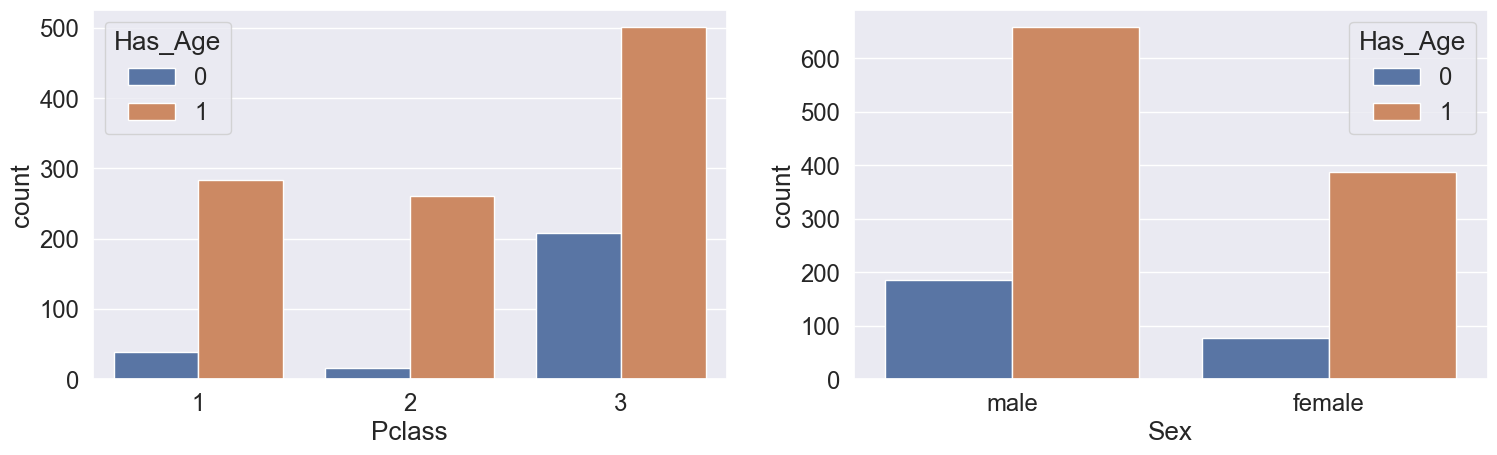

In [25]:
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(x = 'Pclass',hue='Has_Age',data = df_data, ax = ax1)
ax2 = sns.countplot(x = 'Sex',hue='Has_Age',data = df_data, ax = ax2)
pd.crosstab(df_data['Has_Age'],df_data['Sex'],margins=True).round(3)

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

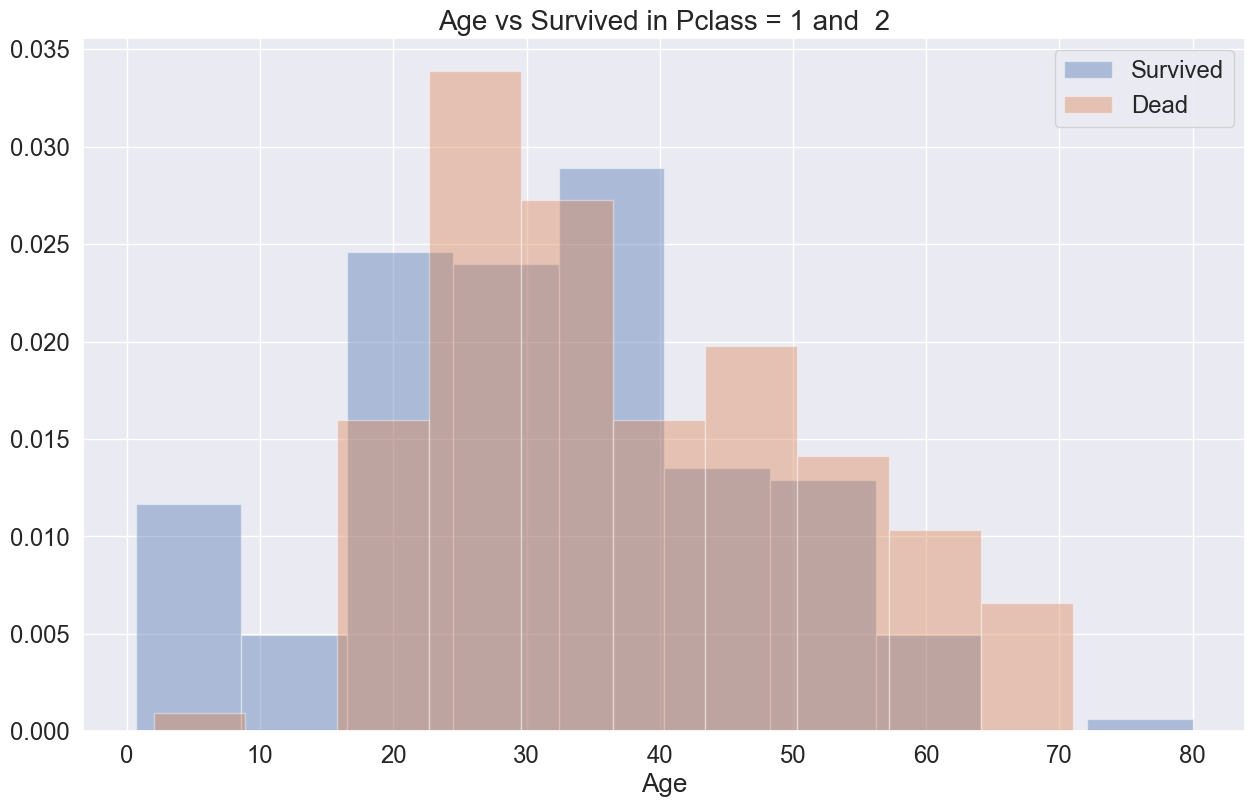

In [26]:
# Masks
Mask_Has_Age_P12_Survived = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 0) )
# Plot
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

In [27]:
# extracted title using name
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = df_data.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

In [28]:
Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
# Filling the missing age
for i in range(0,5):
 # 0 1 2 3 4 5
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')
df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 16.0) * 1 #標示是否未滿16

In [29]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [30]:
minor = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor']
minor_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
minor_Model.fit(X[minor], Y)
print('minor oob score :%.5f' %(minor_Model.oob_score_))

minor oob score :0.84175


In [31]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

minor_pred = minor_Model.predict(X_Submit[minor])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":minor_pred.astype(int)})
submit.to_csv("submit_minor.csv",index=False)

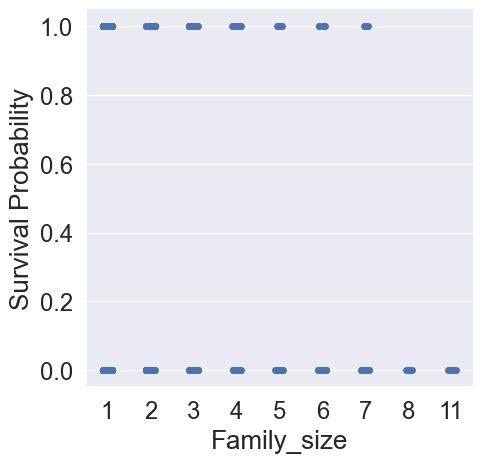

In [32]:
g = sns.catplot(x='Family_size', y='Survived',data=df_data)
g = g.set_ylabels("Survival Probability")

In [33]:
# cut into 3 class
df_data['L_Family'] = df_data['Family_size'].apply(lambda x: 0 if x<= 4 else 1).astype(int)
df_data.loc[ df_data['Family_size'] == 1, 'FamilyClass'] = 0
df_data.loc[ (df_data['Family_size'] <= 4) & (df_data['Family_size'] > 1), 'FamilyClass'] = 1
df_data.loc[ df_data['Family_size'] >= 5, 'FamilyClass'] = 2
df_data['FamilyClass'] = df_data['FamilyClass'].astype(int) 
df_data[['FamilyClass','Survived']].groupby(['FamilyClass']).mean()

,Survived
FamilyClass,
0,0.303538
1,0.578767
2,0.161290


<Axes: title={'center': 'Sex'}, xlabel='Family_size'>

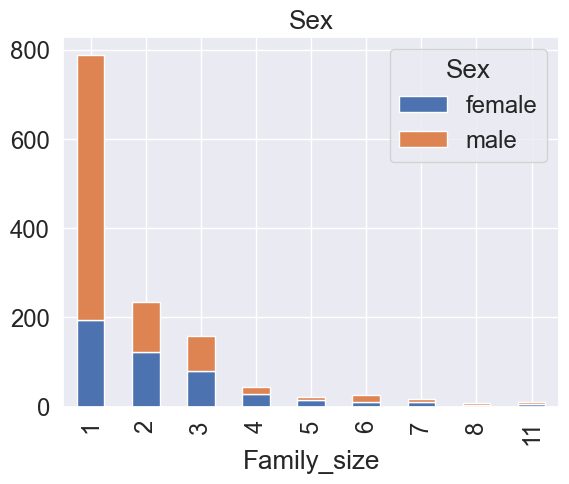

In [34]:
# display(pd.crosstab(df_data['Sex'],df_data['Family_size'],margins=True))
# visualize
pd.crosstab(df_data['Family_size'],df_data['Sex']).plot(kind='bar',stacked=True,title="Sex")

<Axes: title={'center': 'Survived Minor counts'}, xlabel='Family_size'>

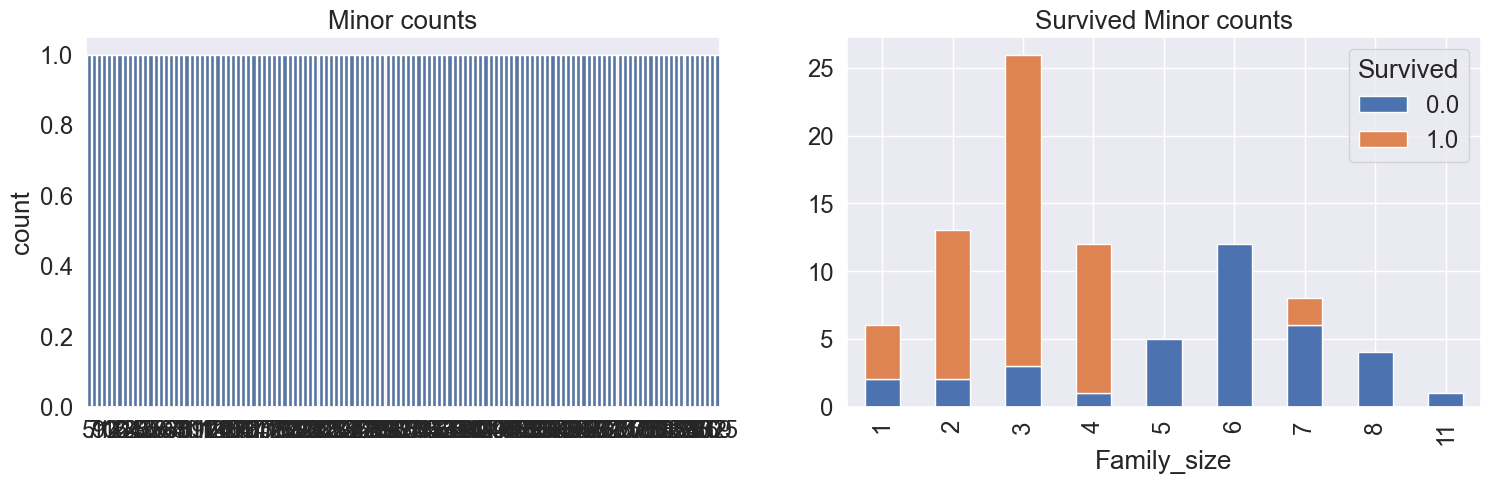

In [35]:
Minor_mask = (df_data.Ti_Minor == 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
sns.countplot(df_data[Minor_mask]['Family_size'],ax=ax1)
ax1.set_title("Minor counts")
pd.crosstab(df_data[Minor_mask]['Family_size'],df_data[Minor_mask]['Survived'])\
.plot(kind='bar',stacked=True,title="Survived Minor counts",ax=ax2)

In [37]:
df_train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [42]:
# 檢查是否有重複的索引
print(df_data.index.duplicated().sum())  # 0 表示無重複


418


In [45]:
# 重置索引以消除重複
df_data = df_data.reset_index(drop=True)


In [46]:
# 檢查 'Embarked' 列中的缺失值
print(df_data['Embarked'].isnull().sum())  # 看是否有 NaN 值

# 查看 'Embarked' 的唯一值
print(df_data['Embarked'].unique())

2
['S' 'C' 'Q' nan]


In [47]:
# 填補缺失值，例如用最常見的值來填補
df_data['Embarked'].fillna(df_data['Embarked'].mode()[0], inplace=True)


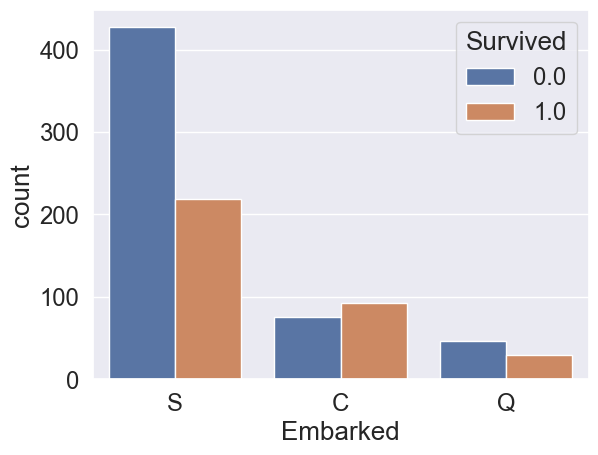

,Embarked,Survived
0,C,0.554
1,Q,0.390
2,S,0.339


In [48]:
# 繪圖：檢查登船地點與生存率的關係
sns.countplot(x='Embarked', hue='Survived', data=df_data)
plt.show()

# 分組計算登船地點與生存率的均值
display(df_data[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().round(3))


In [ ]:
df_data['Embarked_Code'] = df_data['Embarked'].map({'female': 1, 'male': 0}).astype('int')
